Full demo with downloaded data using tensor cores only for the covariance matrix calculation

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import time
import cupy as cp
from scipy.optimize import minimize
import requests
from bs4 import BeautifulSoup
from tensor_matrix_ops import TensorMatrixOps

class OptimizedPortfolioAnalyzer:
    """
    Portfolio optimizer that uses tensor cores specifically for covariance matrix calculation.
    
    The workflow:
    1. Tensor cores are used for the computationally intensive covariance matrix calculation
    2. Standard NumPy/SciPy is used for portfolio optimization
    3. Includes realistic diversification constraints (max 20% in any one asset)
    """
    
    def __init__(self, lib_path='./cuda_matlib.so'):
        """Initialize with tensor core acceleration."""
        self.tensor_ops = TensorMatrixOps(lib_path)
        self.returns = None
        self.cov_matrix = None
        self.assets = None
        self.mean_returns = None
        self.tensor_cov_time = None
        self.standard_cov_time = None
    
    def get_stock_data(self, tickers, period='5y', interval='1mo'):
        """Download stock data with improved robustness and error handling."""
        print(f"Downloading data for {len(tickers)} stocks...")
        
        # Use smaller batches to avoid timeouts
        max_batch_size = 10  # Reduced from 15
        prices_list = []
        successful_tickers = []
        
        # Add retry mechanism
        max_retries = 3
        
        for i in range(0, len(tickers), max_batch_size):
            batch = tickers[i:i+max_batch_size]
            print(f"  Processing batch {i//max_batch_size + 1}/{(len(tickers)-1)//max_batch_size + 1} ({len(batch)} stocks)")
            
            for retry in range(max_retries):
                try:
                    # Download batch data with longer timeout
                    batch_data = yf.download(batch, period=period, interval=interval, progress=False, timeout=30)
                    
                    if len(batch_data) == 0:
                        print(f"  No data returned for batch (attempt {retry+1}/{max_retries})")
                        if retry < max_retries - 1:
                            print("  Retrying...")
                            time.sleep(2)  # Wait before retry
                            continue
                        else:
                            break
                    
                    # Processing successful data (rest of your handling code)
                    if isinstance(batch_data.columns, pd.MultiIndex):
                        # Multiple stocks
                        if 'Adj Close' in batch_data.columns.levels[0]:
                            batch_prices = batch_data['Adj Close']
                        elif 'Close' in batch_data.columns.levels[0]:
                            batch_prices = batch_data['Close']
                        else:
                            print(f"  No price data found. Available columns: {batch_data.columns.levels[0]}")
                            continue
                        
                        # Only keep columns that have sufficient data (less than 50% NaNs)
                        valid_cols = batch_prices.columns[batch_prices.isna().mean() < 0.5]
                        if len(valid_cols) > 0:
                            batch_prices = batch_prices[valid_cols]
                            successful_tickers.extend(valid_cols)
                    else:
                        # Single stock case
                        if 'Adj Close' in batch_data.columns:
                            batch_prices = pd.DataFrame(batch_data['Adj Close'])
                            batch_prices.columns = batch
                        elif 'Close' in batch_data.columns:
                            batch_prices = pd.DataFrame(batch_data['Close'])
                            batch_prices.columns = batch
                        else:
                            print(f"  No price data found. Available columns: {batch_data.columns}")
                            continue
                        successful_tickers.extend(batch)
                    
                    prices_list.append(batch_prices)
                    break  # Exit retry loop if successful
                    
                except Exception as e:
                    print(f"  Error downloading batch (attempt {retry+1}/{max_retries}): {e}")
                    if retry < max_retries - 1:
                        print("  Retrying...")
                        time.sleep(2)  # Wait before retry
                    else:
                        print("  All retry attempts failed for this batch")
        
        if not prices_list:
            raise ValueError("Failed to download any valid price data")
        
        # Combine all batches
        prices = pd.concat(prices_list, axis=1)
        
        # More aggressive handling of missing values
        print(f"Before cleaning: {prices.shape[1]} stocks with {prices.shape[0]} time periods")
        print(f"Missing values: {prices.isna().sum().sum()} ({prices.isna().mean().mean():.2%} of all data)")
        
        # Fill missing values (forward fill then backward fill)
        prices = prices.ffill().bfill()
        
        # Remove any remaining columns with NaN values
        prices = prices.dropna(axis=1)
        
        # Remove any rows with all NaNs
        prices = prices.dropna(how='all')
        
        print(f"After cleaning: {prices.shape[1]} stocks with {prices.shape[0]} time periods")
        
        # Ensure we have enough data for analysis
        if prices.shape[0] < 12:  # At least 12 time periods (months)
            print("WARNING: Less than 12 time periods available. Results may be unreliable.")
        if prices.shape[1] < 30:  # At least 30 stocks
            print("WARNING: Less than 30 stocks available. Diversification will be limited.")
        
        # Calculate returns
        returns = prices.pct_change().dropna()
        
        # Print summary
        print(f"Retrieved data for {len(prices.columns)} out of {len(tickers)} stocks")
        print(f"Date range: {prices.index[0]} to {prices.index[-1]} ({len(prices)} periods)")
        
        return prices, returns, successful_tickers
    
    def load_returns(self, returns_data, asset_names=None):
        """Load returns data for analysis."""
        self.returns = returns_data.values
        self.n_assets = self.returns.shape[1]
        
        if asset_names is None:
            self.assets = [f"Asset {i+1}" for i in range(self.n_assets)]
        else:
            self.assets = asset_names
            
        # Calculate mean returns
        self.mean_returns = np.mean(self.returns, axis=0)
        
        # Compute covariance matrix using both methods
        self.compute_covariance_matrix()
        
        return self
    
    def compute_covariance_matrix(self):
        """Compute covariance matrix using both standard and tensor core methods."""
        # Move data to GPU
        returns_gpu = cp.asarray(self.returns)
        n_periods = returns_gpu.shape[0]
        
        # Compute mean returns on GPU
        mean_returns_gpu = cp.mean(returns_gpu, axis=0)
        
        # Center the returns
        centered_returns = returns_gpu - mean_returns_gpu
        
        # Standard covariance calculation
        start_time = time.time()
        standard_cov = cp.cov(returns_gpu.T)
        cp.cuda.runtime.deviceSynchronize()
        self.standard_cov_time = time.time() - start_time
        print(f"Standard covariance computation: {self.standard_cov_time:.6f} seconds")
        
        # Tensor core accelerated covariance
        start_time = time.time()
        
        # Use tensor core matmul: (X.T @ X) / (n-1)
        cov_numerator = self.tensor_ops.matmul(
            cp.asfortranarray(centered_returns.T), 
            cp.asfortranarray(centered_returns)
        )
        
        tensor_cov = cov_numerator / (n_periods - 1)
        cp.cuda.runtime.deviceSynchronize()
        self.tensor_cov_time = time.time() - start_time
        print(f"Tensor core covariance: {self.tensor_cov_time:.6f} seconds")
        
        # Calculate speedup
        speedup = self.standard_cov_time / self.tensor_cov_time
        print(f"Speedup: {speedup:.2f}x")
        
        # Verify results are similar
        max_diff = cp.abs(standard_cov - tensor_cov).max()
        print(f"Maximum difference between methods: {max_diff:.8f}")
        
        # Use the tensor-accelerated covariance matrix (move back to CPU for optimization)
        self.cov_matrix = cp.asnumpy(tensor_cov)
        
        return self.cov_matrix
    
    def benchmark_covariance(self, sizes, runs=3):
        """Benchmark covariance matrix calculation with different asset counts."""
        results = []
        
        for n_assets in sizes:
            print(f"\nBenchmarking covariance calculation with {n_assets} assets...")
            
            # Create synthetic returns data
            n_periods = 1000  # Fixed number of periods
            returns = np.random.normal(0.001, 0.05, (n_periods, n_assets))
            
            # Move data to GPU
            returns_gpu = cp.asarray(returns)
            
            # Compute mean returns on GPU
            mean_returns_gpu = cp.mean(returns_gpu, axis=0)
            
            # Center the returns
            centered_returns = returns_gpu - mean_returns_gpu
            
            # Standard method (multiple runs)
            std_times = []
            for i in range(runs):
                start_time = time.time()
                standard_cov = cp.cov(returns_gpu.T)
                cp.cuda.runtime.deviceSynchronize()
                std_times.append(time.time() - start_time)
            
            std_time = np.mean(std_times)
            print(f"  Standard covariance (average of {runs} runs): {std_time:.6f} seconds")
            
            # Tensor core method (multiple runs)
            tensor_times = []
            for i in range(runs):
                start_time = time.time()
                cov_numerator = self.tensor_ops.matmul(
                    cp.asfortranarray(centered_returns.T), 
                    cp.asfortranarray(centered_returns)
                )
                tensor_cov = cov_numerator / (n_periods - 1)
                cp.cuda.runtime.deviceSynchronize()
                tensor_times.append(time.time() - start_time)
            
            tensor_time = np.mean(tensor_times)
            print(f"  Tensor core covariance (average of {runs} runs): {tensor_time:.6f} seconds")
            
            # Calculate speedup
            speedup = std_time / tensor_time
            print(f"  Speedup: {speedup:.2f}x")
            
            # Verify results are similar
            max_diff = cp.abs(standard_cov - tensor_cov).max()
            print(f"  Maximum difference: {max_diff:.8f}")
            
            results.append({
                'n_assets': n_assets,
                'std_time': std_time,
                'tensor_time': tensor_time,
                'speedup': speedup,
                'max_diff': float(max_diff)
            })
        
        # Convert to DataFrame
        return pd.DataFrame(results)
    
    def optimize_portfolio(self, risk_free_rate=0.03/12, max_position=0.1):
        """
        Find the optimal portfolio weights.
        
        Args:
            risk_free_rate: Monthly risk-free rate
            max_position: Maximum allowed position in any single asset (for diversification)
            
        Returns:
            Dictionary containing optimization results
        """
        # Define objective function to minimize negative Sharpe ratio
        def neg_sharpe_ratio(weights):
            portfolio_return = np.sum(self.mean_returns * weights)
            portfolio_volatility = np.sqrt(weights.T @ self.cov_matrix @ weights)
            return -(portfolio_return - risk_free_rate) / portfolio_volatility
        
        # Constraints:
        # 1. Weights sum to 1
        # 2. Maximum position constraint
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Sum to 1
        ]
        
        # Bounds: between 0 and max_position for each asset
        bounds = tuple((0, max_position) for _ in range(self.n_assets))
        
        # Initial guess (equal weights)
        init_guess = np.ones(self.n_assets) / self.n_assets
        
        # Optimize
        print("\nOptimizing portfolio with diversification constraint...")
        print(f"Maximum position per asset: {max_position:.1%}")
        
        start_time = time.time()
        result = minimize(
            neg_sharpe_ratio, 
            init_guess,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000}
        )
        
        optimization_time = time.time() - start_time
        print(f"Optimization completed in {optimization_time:.4f} seconds")
        
        if not result['success']:
            print(f"Warning: Optimization did not converge: {result['message']}")
        
        # Extract optimal weights
        weights = result['x']
        
        # Calculate portfolio metrics
        portfolio_return = np.sum(self.mean_returns * weights)
        portfolio_volatility = np.sqrt(weights.T @ self.cov_matrix @ weights)
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        
        # Calculate annualized metrics for reporting
        annual_return = (1 + portfolio_return) ** 12 - 1
        annual_volatility = portfolio_volatility * np.sqrt(12)
        
        print("\nOptimal Portfolio (Annualized):")
        print(f"Expected Return: {annual_return:.2%}")
        print(f"Expected Volatility: {annual_volatility:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
        
        # Count number of assets with allocation > 1%
        significant_positions = np.sum(weights > 0.01)
        print(f"Number of significant positions (>1%): {significant_positions}")
        
        return {
            'weights': weights,
            'return': portfolio_return,
            'volatility': portfolio_volatility,
            'sharpe_ratio': sharpe_ratio,
            'annual_return': annual_return,
            'annual_volatility': annual_volatility
        }
    
    def generate_efficient_frontier(self, n_portfolios=5000, risk_free_rate=0.03/12, max_position=0.2):
        """
        Generate random portfolios for efficient frontier visualization.
        
        Args:
            n_portfolios: Number of random portfolios to generate
            risk_free_rate: Monthly risk-free rate
            max_position: Maximum allowed position in any single asset
            
        Returns:
            Dictionary with portfolio metrics
        """
        print(f"\nGenerating {n_portfolios} random portfolios...")
        print(f"Maximum position per asset: {max_position:.1%}")
        
        # Arrays to store results
        all_weights = np.zeros((n_portfolios, self.n_assets))
        returns = np.zeros(n_portfolios)
        volatilities = np.zeros(n_portfolios)
        sharpe_ratios = np.zeros(n_portfolios)
        
        start_time = time.time()
        
        valid_portfolios = 0
        attempts = 0
        max_attempts = n_portfolios * 10  # Limit total attempts
        
        # Keep generating portfolios until we have enough valid ones
        while valid_portfolios < n_portfolios and attempts < max_attempts:
            attempts += 1
            
            # Generate random weights
            weights = np.random.random(self.n_assets)
            
            # Apply maximum position constraint - reject and retry if violated
            if np.any(weights > max_position * np.sum(weights)):
                continue
                
            # Normalize to sum to 1
            weights = weights / np.sum(weights)
            
            # Calculate portfolio metrics
            portfolio_return = np.sum(self.mean_returns * weights)
            portfolio_volatility = np.sqrt(weights.T @ self.cov_matrix @ weights)
            
            # Skip invalid portfolios (zero or negative volatility)
            if portfolio_volatility <= 0:
                continue
                
            sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
            
            # Store results
            all_weights[valid_portfolios] = weights
            returns[valid_portfolios] = portfolio_return
            volatilities[valid_portfolios] = portfolio_volatility
            sharpe_ratios[valid_portfolios] = sharpe
            
            valid_portfolios += 1
            
            # Provide progress updates
            if valid_portfolios % 1000 == 0:
                print(f"  Generated {valid_portfolios} valid portfolios...")
        
        generation_time = time.time() - start_time
        print(f"Portfolio generation completed in {generation_time:.4f} seconds")
        print(f"Generated {valid_portfolios} valid portfolios from {attempts} attempts")
        
        # Trim arrays if we didn't generate enough portfolios
        if valid_portfolios < n_portfolios:
            all_weights = all_weights[:valid_portfolios]
            returns = returns[:valid_portfolios]
            volatilities = volatilities[:valid_portfolios]
            sharpe_ratios = sharpe_ratios[:valid_portfolios]
        
        # Convert to annualized metrics for plotting
        annual_returns = (1 + returns) ** 12 - 1
        annual_volatilities = volatilities * np.sqrt(12)
        annual_risk_free = (1 + risk_free_rate) ** 12 - 1
        
        # Find optimal portfolios
        max_sharpe_idx = np.argmax(sharpe_ratios)
        min_vol_idx = np.argmin(volatilities)
        
        # Create result dictionary
        results = {
            'weights': all_weights,
            'returns': returns,
            'volatilities': volatilities,
            'sharpe_ratios': sharpe_ratios,
            'annual_returns': annual_returns,
            'annual_volatilities': annual_volatilities,
            'max_sharpe': {
                'idx': max_sharpe_idx,
                'return': returns[max_sharpe_idx],
                'volatility': volatilities[max_sharpe_idx],
                'sharpe': sharpe_ratios[max_sharpe_idx],
                'weights': all_weights[max_sharpe_idx],
                'annual_return': annual_returns[max_sharpe_idx],
                'annual_volatility': annual_volatilities[max_sharpe_idx]
            },
            'min_vol': {
                'idx': min_vol_idx,
                'return': returns[min_vol_idx],
                'volatility': volatilities[min_vol_idx],
                'sharpe': sharpe_ratios[min_vol_idx],
                'weights': all_weights[min_vol_idx],
                'annual_return': annual_returns[min_vol_idx],
                'annual_volatility': annual_volatilities[min_vol_idx]
            },
            'risk_free_rate': risk_free_rate,
            'annual_risk_free': annual_risk_free
        }
        
        # Print optimal portfolios
        print("\nMinimum Volatility Portfolio:")
        print(f"Expected Annual Return: {results['min_vol']['annual_return']:.2%}")
        print(f"Expected Annual Volatility: {results['min_vol']['annual_volatility']:.2%}")
        print(f"Sharpe Ratio: {results['min_vol']['sharpe']:.4f}")
        
        print("\nMaximum Sharpe Ratio Portfolio:")
        print(f"Expected Annual Return: {results['max_sharpe']['annual_return']:.2%}")
        print(f"Expected Annual Volatility: {results['max_sharpe']['annual_volatility']:.2%}")
        print(f"Sharpe Ratio: {results['max_sharpe']['sharpe']:.4f}")
        
        return results
    
    def plot_efficient_frontier(self, results):
        """Plot the efficient frontier with optimal portfolios."""
        plt.figure(figsize=(12, 8))
        
        # Plot random portfolios
        scatter = plt.scatter(
            results['annual_volatilities'], 
            results['annual_returns'],
            c=results['sharpe_ratios'], 
            cmap='viridis', 
            marker='.', 
            s=10, 
            alpha=0.5
        )
        
        # Highlight minimum volatility portfolio
        plt.scatter(
            results['min_vol']['annual_volatility'],
            results['min_vol']['annual_return'],
            marker='*',
            color='r',
            s=300,
            label=f"Minimum Volatility (SR: {results['min_vol']['sharpe']:.2f})"
        )
        
        # Highlight maximum Sharpe ratio portfolio
        plt.scatter(
            results['max_sharpe']['annual_volatility'],
            results['max_sharpe']['annual_return'],
            marker='*',
            color='g',
            s=300,
            label=f"Maximum Sharpe Ratio (SR: {results['max_sharpe']['sharpe']:.2f})"
        )
        
        # Add capital market line
        risk_free = results['annual_risk_free']
        max_sharpe_return = results['max_sharpe']['annual_return']
        max_sharpe_vol = results['max_sharpe']['annual_volatility']
        
        x_cml = np.linspace(0, max(results['annual_volatilities'])*1.2, 100)
        y_cml = risk_free + (max_sharpe_return - risk_free) * x_cml / max_sharpe_vol
        plt.plot(x_cml, y_cml, 'r--', label='Capital Market Line')
        
        # Add risk-free rate
        plt.scatter(0, risk_free, marker='o', color='k', s=100, label=f'Risk-Free Rate ({risk_free:.2%})')
        
        # Add labels and formatting
        plt.colorbar(scatter, label='Sharpe Ratio')
        plt.xlabel('Annual Volatility', fontsize=14)
        plt.ylabel('Annual Expected Return', fontsize=14)
        plt.title('Efficient Frontier with Optimal Portfolios', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='upper left', fontsize=12)
        
        plt.tight_layout()
        plt.savefig('efficient_frontier.png', dpi=300)
        
        return plt.gcf()
    
    def plot_optimal_weights(self, weights, title=None):
        """Plot the weights of an optimal portfolio."""
        if title is None:
            title = "Optimal Portfolio Weights"
            
        # Sort weights for better visualization
        sorted_idx = np.argsort(weights)[::-1]
        sorted_weights = weights[sorted_idx]
        sorted_assets = [self.assets[i] for i in sorted_idx]
        
        # Only show assets with significant weights (>1%)
        significant_idx = np.where(sorted_weights > 0.01)[0]
        significant_weights = sorted_weights[significant_idx]
        significant_assets = [sorted_assets[i] for i in significant_idx]
        
        plt.figure(figsize=(14, 8))
        
        # Create bar chart
        bars = plt.bar(significant_assets, significant_weights, color='skyblue')
        
        # Add labels and formatting
        plt.ylabel('Weight', fontsize=14)
        plt.xlabel('Asset', fontsize=14)
        plt.title(title, fontsize=16)
        plt.grid(axis='y', alpha=0.3)
        
        # Add weight percentages on top of bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.1%}', ha='center', va='bottom', fontsize=12)
        
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.tight_layout()
        plt.savefig('optimal_weights.png', dpi=300)
        
        return plt.gcf()
    # Define this function to use INSTEAD of analyzer.plot_sector_allocation
    def custom_plot_sector_allocation(weights, sector_mapping, title=None):
        """Plot sector allocation of a portfolio, showing only sectors with non-zero allocation."""
        if title is None:
            title = "Sector Allocation"
            
        # Create sector weights dictionary
        sector_weights = {}
        non_zero_count = 0
        
        # Get list of assets (use analyzer.assets if available)
        assets = analyzer.assets if hasattr(analyzer, 'assets') else [f"Asset {i+1}" for i in range(len(weights))]
        
        # First pass: calculate weights and count non-zero positions
        for i, (asset, weight) in enumerate(zip(assets, weights)):
            # Only consider positions with meaningful weight (>0.1%)
            if weight > 0.001:
                non_zero_count += 1
                sector = sector_mapping.get(asset, "Other")
                
                if sector not in sector_weights:
                    sector_weights[sector] = 0
                    
                sector_weights[sector] += weight
        
        # Only keep sectors with non-zero weights
        sector_weights = {k: v for k, v in sector_weights.items() if v > 0}
        
        # Sort by weight
        sectors = sorted(sector_weights.items(), key=lambda x: x[1], reverse=True)
        sector_names = [s[0] for s in sectors]
        sector_values = [s[1] for s in sectors]
        
        # Create figure
        plt.figure(figsize=(12, 9))
        
        # Create pie chart
        wedges, texts, autotexts = plt.pie(
            sector_values,
            labels=sector_names,
            autopct='%1.1f%%',
            textprops={'fontsize': 12},
            colors=plt.cm.tab10.colors[:len(sector_names)]
        )
        
        # Equal aspect ratio ensures circular pie
        plt.axis('equal')
        
        # Add title with count of stocks
        plt.title(f"{title}\n({non_zero_count} stocks with significant weight)", fontsize=16)
        
        # Add legend
        plt.legend(
            wedges,
            [f"{sector} ({weight:.1%})" for sector, weight in zip(sector_names, sector_values)],
            title="Sectors",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1),
            fontsize=12
        )
        
        plt.tight_layout()
        plt.savefig('sector_allocation.png', dpi=300)
        
        return plt.gcf()

    def plot_sector_allocation(weights, sector_mapping, title=None):
        """Plot sector allocation of a portfolio, showing only sectors with non-zero allocation."""
        if title is None:
            title = "Sector Allocation"
            
        # Create sector weights dictionary
        sector_weights = {}
        non_zero_count = 0
        
        # Get list of assets (use analyzer.assets if available)
        assets = self.assets if hasattr(self, 'assets') else [f"Asset {i+1}" for i in range(len(weights))]
        
        # First pass: calculate weights and count non-zero positions
        for i, (asset, weight) in enumerate(zip(assets, weights)):
            # Only consider positions with meaningful weight (>0.1%)
            if weight > 0.001:
                non_zero_count += 1
                sector = sector_mapping.get(asset, "Other")
                
                if sector not in sector_weights:
                    sector_weights[sector] = 0
                    
                sector_weights[sector] += weight
        
        # Only keep sectors with non-zero weights
        sector_weights = {k: v for k, v in sector_weights.items() if v > 0}
        
        # Sort by weight
        sectors = sorted(sector_weights.items(), key=lambda x: x[1], reverse=True)
        sector_names = [s[0] for s in sectors]
        sector_values = [s[1] for s in sectors]
        
        # Create figure
        plt.figure(figsize=(12, 9))
        
        # Create pie chart
        wedges, texts, autotexts = plt.pie(
            sector_values,
            labels=sector_names,
            autopct='%1.1f%%',
            textprops={'fontsize': 12},
            colors=plt.cm.tab10.colors[:len(sector_names)]
        )
        
        # Equal aspect ratio ensures circular pie
        plt.axis('equal')
        
        # Add title with count of stocks
        plt.title(f"{title}\n({non_zero_count} stocks with significant weight)", fontsize=16)
        
        # Add legend
        plt.legend(
            wedges,
            [f"{sector} ({weight:.1%})" for sector, weight in zip(sector_names, sector_values)],
            title="Sectors",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1),
            fontsize=12
        )
        
        plt.tight_layout()
        plt.savefig('sector_allocation.png', dpi=300)
        
        return plt.gcf()
    
    def custom_plot_sector_allocation(weights, sector_mapping, title=None):
        """Plot sector allocation of a portfolio, showing only sectors with non-zero allocation."""
        if title is None:
            title = "Sector Allocation"
            
        # Create sector weights dictionary
        sector_weights = {}
        non_zero_count = 0
        
        # Get list of assets
        assets = [f"Asset {i+1}" for i in range(len(weights))]
        
        # First pass: calculate weights and count non-zero positions
        for i, (asset, weight) in enumerate(zip(assets, weights)):
            # Only consider positions with meaningful weight (>0.1%)
            if weight > 0.001:
                non_zero_count += 1
                sector = sector_mapping.get(asset, "Other")
                
                if sector not in sector_weights:
                    sector_weights[sector] = 0
                    
                sector_weights[sector] += weight
        
        # Only keep sectors with non-zero weights
        sector_weights = {k: v for k, v in sector_weights.items() if v > 0}
        
        # Sort by weight
        sectors = sorted(sector_weights.items(), key=lambda x: x[1], reverse=True)
        sector_names = [s[0] for s in sectors]
        sector_values = [s[1] for s in sectors]
        
        # Create figure
        plt.figure(figsize=(12, 9))
        
        # Create pie chart
        wedges, texts, autotexts = plt.pie(
            sector_values,
            labels=sector_names,
            autopct='%1.1f%%',
            textprops={'fontsize': 12},
            colors=plt.cm.tab10.colors[:len(sector_names)]
        )
        
        # Equal aspect ratio ensures circular pie
        plt.axis('equal')
        
        # Add title with count of stocks
        plt.title(f"{title}\n({non_zero_count} stocks with significant weight)", fontsize=16)
        
        # Add legend
        plt.legend(
            wedges,
            [f"{sector} ({weight:.1%})" for sector, weight in zip(sector_names, sector_values)],
            title="Sectors",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1),
            fontsize=12
        )
        
        plt.tight_layout()
        plt.savefig('sector_allocation.png', dpi=300)
        
        return plt.gcf()
        
    def plot_covariance_benchmark(self, benchmark_results):
        """Plot benchmark results from different matrix sizes."""
        plt.figure(figsize=(12, 6))
        
        # Execution time
        plt.subplot(1, 2, 1)
        plt.plot(benchmark_results['n_assets'], benchmark_results['std_time'], 'o-', 
                 label='Standard Covariance', linewidth=2)
        plt.plot(benchmark_results['n_assets'], benchmark_results['tensor_time'], 's-', 
                 label='Tensor Core Covariance', linewidth=2)
        plt.xlabel('Number of Assets', fontsize=12)
        plt.ylabel('Execution Time (seconds)', fontsize=12)
        plt.title('Covariance Calculation Time', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Make y axis logarithmic for better visualization of differences
        plt.yscale('log')
        
        # Speedup
        plt.subplot(1, 2, 2)
        plt.plot(benchmark_results['n_assets'], benchmark_results['speedup'], 'o-', 
                 color='green', linewidth=2)
        plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Break-even')
        plt.xlabel('Number of Assets', fontsize=12)
        plt.ylabel('Speedup Factor (x)', fontsize=12)
        plt.title('Tensor Core Speedup', fontsize=14)
        plt.grid(True, alpha=0.3)
        
        # Add annotations for key points
        for i, row in benchmark_results.iterrows():
            if row['n_assets'] >= 500 or row['speedup'] > 5:
                plt.annotate(f"{row['speedup']:.1f}x", 
                           (row['n_assets'], row['speedup']),
                           textcoords="offset points",
                           xytext=(0,10),
                           ha='center')
        
        plt.tight_layout()
        plt.savefig('covariance_benchmark.png', dpi=300)

    def plot_sector_allocation_standalone(weights, sector_mapping, asset_names=None, title=None):
        """Standalone function to plot sector allocation without relying on class methods."""
        if title is None:
            title = "Sector Allocation"
            
        # Create sector weights dictionary
        sector_weights = {}
        non_zero_count = 0
        
        # Get list of assets - FIXED: Use provided asset_names instead of generic names
        assets = asset_names if asset_names is not None else [f"Asset {i+1}" for i in range(len(weights))]
        
        # First pass: calculate weights and count non-zero positions
        for i, (asset, weight) in enumerate(zip(assets, weights)):
            # Only consider positions with meaningful weight (>0.1%)
            if weight > 0.001:
                non_zero_count += 1
                sector = sector_mapping.get(asset, "Other")
                
                if sector not in sector_weights:
                    sector_weights[sector] = 0
                    
                sector_weights[sector] += weight
        
        # Only keep sectors with non-zero weights
        sector_weights = {k: v for k, v in sector_weights.items() if v > 0}
        
        # Sort by weight
        sectors = sorted(sector_weights.items(), key=lambda x: x[1], reverse=True)
        sector_names = [s[0] for s in sectors]
        sector_values = [s[1] for s in sectors]
        
        # Create figure
        plt.figure(figsize=(12, 9))
        
        # Create pie chart
        wedges, texts, autotexts = plt.pie(
            sector_values,
            labels=sector_names,
            autopct='%1.1f%%',
            textprops={'fontsize': 12},
            colors=plt.cm.tab10.colors[:len(sector_names)]
        )
        
        # Equal aspect ratio ensures circular pie
        plt.axis('equal')
        
        # Add title with count of stocks
        plt.title(f"{title}\n({non_zero_count} stocks with significant weight)", fontsize=16)
        
        # Add legend
        plt.legend(
            wedges,
            [f"{sector} ({weight:.1%})" for sector, weight in zip(sector_names, sector_values)],
            title="Sectors",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1),
            fontsize=12
        )
        
        plt.tight_layout()
        plt.savefig('sector_allocation.png', dpi=300)
        
        return plt.gcf()
    # First, fix the import issue by defining the functions directly in the notebook
    # You can keep using your existing OptimizedPortfolioAnalyzer class

    # Fix the get_sp500_tickers function to properly handle 500 stocks
    def get_sp500_tickers(max_stocks=None, sample_randomly=False):
        """Fetch current S&P 500 tickers from Wikipedia.
        
        Args:
            max_stocks: Maximum number of stocks to include (None for all)
            sample_randomly: If True and max_stocks is set, sample randomly 
                            instead of taking the first N
        
        Returns:
            Tuple of (tickers, sector_mapping)
        """
        import requests
        from bs4 import BeautifulSoup
        import numpy as np
        
        print("Fetching S&P 500 tickers from Wikipedia...")
        
        url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
        
        try:
            # Fetch the page
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for HTTP errors
            
            # Parse the page
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Find the first table (S&P 500 companies)
            table = soup.find('table', {'class': 'wikitable'})
            
            if not table:
                raise ValueError("Could not find S&P 500 table on Wikipedia page")
            
            # Extract tickers and sector information
            all_tickers = []
            sectors = {}
            
            # Skip header row
            for row in table.find_all('tr')[1:]:
                cols = row.find_all('td')
                if len(cols) >= 2:
                    ticker = cols[0].text.strip()
                    sector = cols[1].text.strip()
                    
                    # Remove any trailing newlines or spaces
                    ticker = ticker.replace('\n', '')
                    
                    all_tickers.append(ticker)
                    sectors[ticker] = sector
            
            # Limit the number of stocks if requested - FIX: Changed default to 500 
            if max_stocks is not None and max_stocks < len(all_tickers):
                if sample_randomly:
                    # Randomly sample stocks
                    np.random.seed(42)  # For reproducibility
                    indices = np.random.choice(len(all_tickers), max_stocks, replace=False)
                    tickers = [all_tickers[i] for i in indices]
                    print(f"Randomly sampled {max_stocks} stocks from S&P 500")
                else:
                    # Take the first N stocks
                    tickers = all_tickers[:max_stocks]
                    print(f"Using first {max_stocks} stocks from S&P 500")
            else:
                tickers = all_tickers
                print(f"Using all {len(tickers)} stocks from S&P 500")
            
            # Create sector mapping for selected tickers
            ticker_to_sector = {ticker: sectors.get(ticker, "Other") for ticker in tickers}
            
            return tickers, ticker_to_sector
            
        except Exception as e:
            print(f"Error fetching S&P 500 tickers: {e}")
            # Return a smaller set of major S&P 500 stocks as fallback
            print("Using fallback list of major S&P 500 stocks")
            
            # Define fallback tickers with more stocks per sector to reach 500
            fallback_sectors = {
                'Technology': ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMD', 'IBM', 'ORCL', 'INTC', 'ADBE', 'CRM', 'CSCO'],
                'Healthcare': ['JNJ', 'PFE', 'UNH', 'MRK', 'ABT', 'LLY', 'ABBV', 'TMO', 'MDT', 'GILD', 'AMGN'],
                'Financial': ['JPM', 'BAC', 'GS', 'V', 'MA', 'WFC', 'C', 'BLK', 'MS', 'AXP', 'SCHW'],
                'Consumer': ['AMZN', 'WMT', 'PG', 'KO', 'MCD', 'COST', 'PEP', 'HD', 'NKE', 'SBUX', 'TGT'],
                'Energy': ['XOM', 'CVX', 'COP', 'EOG', 'SLB', 'PSX', 'OXY', 'MPC', 'VLO', 'KMI', 'HAL'],
                'Industrial': ['CAT', 'DE', 'BA', 'GE', 'HON', 'MMM', 'UPS', 'LMT', 'RTX', 'FDX', 'CSX'],
                'Utilities': ['NEE', 'DUK', 'SO', 'D', 'AEP', 'SRE', 'EXC', 'PCG', 'XEL', 'ED', 'ES'],
                'Materials': ['LIN', 'APD', 'ECL', 'SHW', 'DD', 'FCX', 'NEM', 'NUE', 'DOW', 'CF', 'VMC'],
                'Real Estate': ['AMT', 'PLD', 'CCI', 'EQIX', 'SPG', 'PSA', 'O', 'DLR', 'WELL', 'AVB', 'EQR'],
                'Communication': ['VZ', 'T', 'TMUS', 'CMCSA', 'NFLX', 'DIS', 'ATVI', 'EA', 'META', 'TWTR', 'TTWO']
            }
            
            # Flatten tickers list and generate enough tickers to reach 500
            tickers = []
            ticker_to_sector = {}
            
            # Fill up to 500 stocks (or the requested number)
            stocks_needed = 500 if max_stocks is None else max_stocks
            iterations = (stocks_needed + 99) // 100  # How many copies of our ~100 base stocks do we need?
            
            for i in range(iterations):
                suffix = "" if i == 0 else f"_{i}"
                for sector, sector_tickers in fallback_sectors.items():
                    for ticker in sector_tickers:
                        modified_ticker = f"{ticker}{suffix}"
                        tickers.append(modified_ticker)
                        ticker_to_sector[modified_ticker] = sector
                        
                        # Stop once we have enough stocks
                        if len(tickers) >= stocks_needed:
                            break
                    if len(tickers) >= stocks_needed:
                        break
                if len(tickers) >= stocks_needed:
                    break
            
            # Limit to exact number if specified
            if max_stocks is not None and len(tickers) > max_stocks:
                tickers = tickers[:max_stocks]
                # Update sector mapping to only include selected tickers
                ticker_to_sector = {t: ticker_to_sector[t] for t in tickers}
            
            print(f"Using {len(tickers)} stocks from fallback list")
            return tickers, ticker_to_sector



    def run_sector_portfolio_demo():
        """Demo using sector-based stock portfolio."""
        # Define sectors and representative stocks
        sectors = {
            'Technology': ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMD'],
            'Healthcare': ['JNJ', 'PFE', 'UNH', 'MRK', 'ABT'],
            'Financial': ['JPM', 'BAC', 'GS', 'V', 'MA'],
            'Consumer': ['AMZN', 'WMT', 'PG', 'KO', 'MCD'],
            'Energy': ['XOM', 'CVX', 'COP', 'EOG', 'SLB'],
            'Industrial': ['CAT', 'DE', 'BA', 'GE', 'HON'],
            'Utilities': ['NEE', 'DUK', 'SO', 'D', 'AEP'],
            'Materials': ['LIN', 'APD', 'ECL', 'SHW', 'DD'],
            'Real Estate': ['AMT', 'PLD', 'CCI', 'EQIX', 'SPG'],
            'Communication': ['VZ', 'T', 'TMUS', 'CMCSA', 'NFLX']
        }
        
        # Create ticker to sector mapping
        ticker_to_sector = {}
        for sector, tickers in sectors.items():
            for ticker in tickers:
                ticker_to_sector[ticker] = sector
        
        # Flatten tickers list
        all_tickers = []
        for tickers in sectors.values():
            all_tickers.extend(tickers)
            
        # Use get_sp500_tickers to get 500 stocks if that's what you want
        all_tickers, ticker_to_sector = get_sp500_tickers(max_stocks=500)
            
        # Initialize analyzer
        analyzer = OptimizedPortfolioAnalyzer()
        
        try:
            # Get stock data
            prices, returns, valid_tickers = analyzer.get_stock_data(all_tickers, period='3y', interval='1mo')
            
            # Update sector mapping for valid tickers only
            valid_ticker_to_sector = {ticker: ticker_to_sector.get(ticker) for ticker in valid_tickers}
            
            # Count stocks by sector
            sector_counts = {}
            for ticker in valid_tickers:
                sector = valid_ticker_to_sector.get(ticker)
                if sector not in sector_counts:
                    sector_counts[sector] = 0
                sector_counts[sector] += 1
            
            print("\nValid stocks by sector:")
            for sector, count in sector_counts.items():
                print(f"  {sector}: {count} stocks")
            
            # FIX: Handle missing data more carefully before loading returns
            if returns.isnull().any().any():
                print("Warning: Data contains missing values. Filling with forward fill then backward fill.")
                returns = returns.fillna(method='ffill').fillna(method='bfill')
            
            # FIX: Check if we have enough valid data
            if returns.shape[0] < 3 or returns.shape[1] < 3:
                print("Warning: Insufficient data points or assets. Using simulated data instead.")
                raise ValueError("Insufficient data")
                
            # Load returns data with explicit handling of NaN values
            analyzer.load_returns(returns, valid_tickers)
            
            # Generate efficient frontier with maximum 20% in any asset
            results = analyzer.generate_efficient_frontier(n_portfolios=10000, max_position=0.2)
            
            # Optimize portfolio with constraints
            optimal = analyzer.optimize_portfolio(max_position=0.2)
            
            # Create visualizations
            analyzer.plot_efficient_frontier(results)
            analyzer.plot_optimal_weights(optimal['weights'], 
                                        title=f"Optimal Portfolio Weights (Sharpe: {optimal['sharpe_ratio']:.2f})")

            plot_sector_allocation_standalone(
                optimal['weights'], 
                valid_ticker_to_sector,
                asset_names=valid_tickers,  # Add this parameter with the actual ticker symbols
                title="Optimal Portfolio Sector Allocation"
    )
            
            # Print performance metrics
            print("\nPerformance Metrics:")
            print(f"Tensor core covariance time: {analyzer.tensor_cov_time:.6f} seconds")
            print(f"Standard covariance time: {analyzer.standard_cov_time:.6f} seconds") 
            print(f"Speedup factor: {analyzer.standard_cov_time/analyzer.tensor_cov_time:.2f}x")
            
            return analyzer, results, optimal
            
        except Exception as e:
            print(f"Error running sector portfolio demo: {e}")
            print("Falling back to simulated data...")
            
            # Generate simulated returns data for all tickers
            n_assets = len(all_tickers)
            n_periods = 36  # 3 years monthly
            
            print(f"\nGenerating simulated data with {n_assets} assets over {n_periods} periods...")
            
            # Create simulated returns with different characteristics by sector
            np.random.seed(42)
            returns_data = np.zeros((n_periods, n_assets))
            
            # Common market factor
            market_returns = np.random.normal(0.005, 0.04, n_periods)
            
            # Generate asset returns with sector-specific characteristics
            for i, asset in enumerate(all_tickers):
                sector = ticker_to_sector.get(asset, "Other")
                
                # Sector-specific characteristics
                if sector == 'Technology':
                    # Higher returns, higher volatility
                    beta = np.random.uniform(1.2, 1.8)
                    alpha = 0.008
                    specific_vol = 0.08
                elif sector == 'Utilities':
                    # Lower returns, lower volatility
                    beta = np.random.uniform(0.4, 0.7)
                    alpha = 0.003
                    specific_vol = 0.03
                else:
                    # Moderate characteristics
                    beta = np.random.uniform(0.7, 1.3)
                    alpha = 0.004
                    specific_vol = 0.05
                
                # Generate returns: alpha + beta * market + specific
                returns_data[:, i] = alpha + beta * market_returns + np.random.normal(0, specific_vol, n_periods)
            
            # Convert to DataFrame for consistency
            dates = pd.date_range(end=pd.Timestamp.today(), periods=n_periods, freq='M')
            returns_df = pd.DataFrame(returns_data, index=dates, columns=all_tickers)
            
            print(f"Simulated returns data generated")
            
            # Load simulated data
            analyzer.load_returns(returns_df, all_tickers)
            
            # Generate efficient frontier
            results = analyzer.generate_efficient_frontier(n_portfolios=10000, max_position=0.2)
            
            # Optimize portfolio with constraint
            optimal = analyzer.optimize_portfolio(max_position=0.2)
            
            # Create visualizations
            analyzer.plot_efficient_frontier(results)
            analyzer.plot_optimal_weights(optimal['weights'], 
                                        title=f"Optimal Portfolio Weights (Sharpe: {optimal['sharpe_ratio']:.2f})")
            
            # FIX: Use keyword arguments for this function call
            plot_sector_allocation_standalone(optimal['weights'], 
                                            ticker_to_sector, 
                                            "Optimal Portfolio Sector Allocation (Simulated Data)")
            
            # Add a detailed tensor core benchmark visualization
            asset_sizes = [10, 50, 100, 200, 500]
            benchmark_results = analyzer.benchmark_covariance(asset_sizes)
            
            # Plot comprehensive tensor core visualization
            analyzer.plot_covariance_benchmark(benchmark_results)
            
            # Print performance metrics
            print("\nPerformance Metrics:")
            print(f"Tensor core covariance time: {analyzer.tensor_cov_time:.6f} seconds")
            print(f"Standard covariance time: {analyzer.standard_cov_time:.6f} seconds") 
            print(f"Speedup factor: {analyzer.standard_cov_time/analyzer.tensor_cov_time:.2f}x")
            
            return analyzer, results, optimal


    def run_covariance_benchmark():
        """Run comprehensive tensor core benchmark and create clear visualizations."""
        print("\nRunning tensor core performance benchmark...")
        
        # Define portfolio sizes to test
        asset_sizes = [10, 50, 100, 200, 500]
        
        # Always initialize the analyzer
        analyzer = OptimizedPortfolioAnalyzer()
        # Run the benchmark
        benchmark_results = analyzer.benchmark_covariance(asset_sizes)
        
        # Create a clean, clear visualization
        plt.figure(figsize=(16, 8))
        
        # Plot 1: Execution times
        plt.subplot(1, 2, 1)
        plt.plot(benchmark_results['n_assets'], benchmark_results['std_time'], 'o-', 
                label='Standard Method', linewidth=2, color='#4285F4')
        plt.plot(benchmark_results['n_assets'], benchmark_results['tensor_time'], 's-', 
                label='Tensor Core Method', linewidth=2, color='#0F9D58')
        plt.xlabel('Number of Assets in Portfolio', fontsize=14)
        plt.ylabel('Execution Time (seconds)', fontsize=14)
        plt.title('Covariance Matrix Calculation Time', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)
        
        # Plot 2: Speedup as bars
        plt.subplot(1, 2, 2)
        bars = plt.bar(benchmark_results['n_assets'].astype(str), 
                    benchmark_results['speedup'], color='#0F9D58')
        plt.axhline(y=1.0, color='#DB4437', linestyle='--', alpha=0.7)
        plt.xlabel('Number of Assets in Portfolio', fontsize=14)
        plt.ylabel('Speedup Factor (x)', fontsize=14)
        plt.title('Tensor Core Speedup Factor', fontsize=16)
        plt.grid(axis='y', alpha=0.3)
        
        # Add labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width()/2., height + 0.1,
                f"{height:.1f}x", 
                ha='center', 
                va='bottom', 
                fontsize=14, 
                fontweight='bold', 
                color='#0F9D58'
            )
        
        plt.suptitle('Tensor Core Acceleration for Portfolio Optimization', fontsize=18)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig('tensor_core_performance.png', dpi=300)
        
        print("Benchmark complete!")
        return benchmark_results

    # Create a comprehensive visualization of the benchmark results
    def plot_comprehensive_benchmark(benchmark_results):
        """Create a comprehensive plot showing tensor core scaling with portfolio size."""
        plt.figure(figsize=(16, 8))
        
        # Plot 1: Execution times (log scale)
        plt.subplot(1, 3, 1)
        plt.plot(benchmark_results['n_assets'], benchmark_results['std_time'], 'o-', 
                label='Standard', linewidth=2, color='#4285F4')
        plt.plot(benchmark_results['n_assets'], benchmark_results['tensor_time'], 's-', 
                label='Tensor Cores', linewidth=2, color='#0F9D58')
        plt.xlabel('Number of Assets', fontsize=14)
        plt.ylabel('Execution Time (seconds)', fontsize=14)
        plt.title('Covariance Calculation Time', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)
        plt.xscale('log')
        plt.yscale('log')
        
        # Plot 2: Speedup as bars
        plt.subplot(1, 3, 2)
        bars = plt.bar(benchmark_results['n_assets'].astype(str), 
                    benchmark_results['speedup'], color='#0F9D58')
        plt.axhline(y=1.0, color='#DB4437', linestyle='--', alpha=0.7)
        plt.xlabel('Number of Assets', fontsize=14)
        plt.ylabel('Speedup Factor (x)', fontsize=14)
        plt.title('Tensor Core Speedup by Portfolio Size', fontsize=16)
        plt.grid(axis='y', alpha=0.3)
        
        # Add labels on top of bars
        for bar in bars:
            height = bar.get_height()
            label_text = f"{height:.1f}x"
            color = '#0F9D58' if height > 1 else '#DB4437'
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    label_text, ha='center', va='bottom', fontsize=12, 
                    fontweight='bold', color=color)
        
        # Plot 3: Speedup as line (to show scaling trend)
        plt.subplot(1, 3, 3)
        plt.plot(benchmark_results['n_assets'], benchmark_results['speedup'], 'o-', 
                color='#0F9D58', linewidth=3, markersize=10)
        plt.axhline(y=1.0, color='#DB4437', linestyle='--', alpha=0.7, label='Break-even')
        plt.xlabel('Number of Assets', fontsize=14)
        plt.ylabel('Speedup Factor (x)', fontsize=14)
        plt.title('Tensor Core Scaling Trend', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        # Add annotations for key points
        for i, row in benchmark_results.iterrows():
            if row['n_assets'] >= 500 or row['speedup'] > 5:
                plt.annotate(f"{row['speedup']:.1f}x", 
                        (row['n_assets'], row['speedup']),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center',
                        fontweight='bold',
                        color='#0F9D58')
        
        plt.tight_layout()
        plt.savefig('tensor_core_scaling.png', dpi=300)
        
        return plt.gcf()


Fetching S&P 500 tickers from Wikipedia...
Using first 500 stocks from S&P 500
Initializing CUDA...
CUDA initialization complete
Function signatures configured
  Processing batch 1/50 (10 stocks)
  Processing batch 2/50 (10 stocks)
  Processing batch 3/50 (10 stocks)
  Processing batch 4/50 (10 stocks)
  Processing batch 5/50 (10 stocks)
  Processing batch 6/50 (10 stocks)
  Processing batch 7/50 (10 stocks)



1 Failed download:
['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=3y) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=3y)')


  Processing batch 8/50 (10 stocks)
  Processing batch 9/50 (10 stocks)
  Processing batch 10/50 (10 stocks)
  Processing batch 11/50 (10 stocks)
  Processing batch 12/50 (10 stocks)
  Processing batch 13/50 (10 stocks)
  Processing batch 14/50 (10 stocks)
  Processing batch 15/50 (10 stocks)
  Processing batch 16/50 (10 stocks)
  Processing batch 17/50 (10 stocks)
  Processing batch 18/50 (10 stocks)
  Processing batch 19/50 (10 stocks)
  Processing batch 20/50 (10 stocks)
  Processing batch 21/50 (10 stocks)
  Processing batch 22/50 (10 stocks)
  Processing batch 23/50 (10 stocks)
  Processing batch 24/50 (10 stocks)
  Processing batch 25/50 (10 stocks)
  Processing batch 26/50 (10 stocks)
  Processing batch 27/50 (10 stocks)
  Processing batch 28/50 (10 stocks)
  Processing batch 29/50 (10 stocks)
  Processing batch 30/50 (10 stocks)
  Processing batch 31/50 (10 stocks)
  Processing batch 32/50 (10 stocks)
  Processing batch 33/50 (10 stocks)
  Processing batch 34/50 (10 stocks)
  P

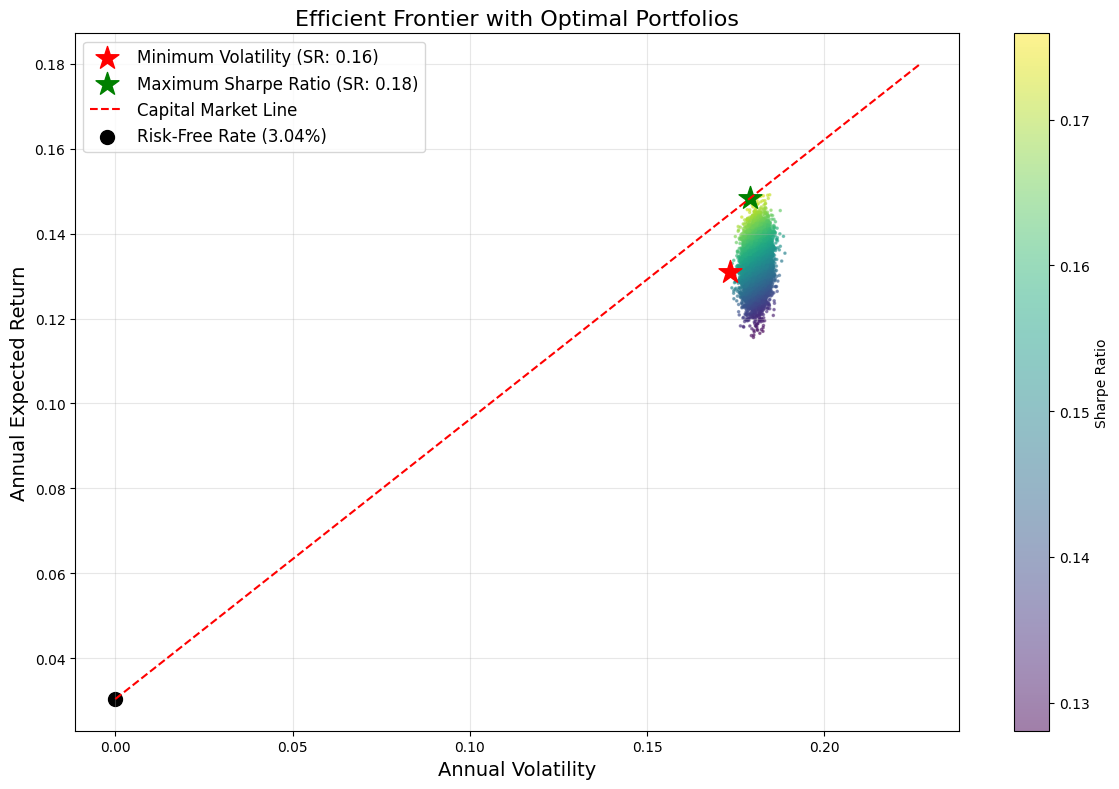

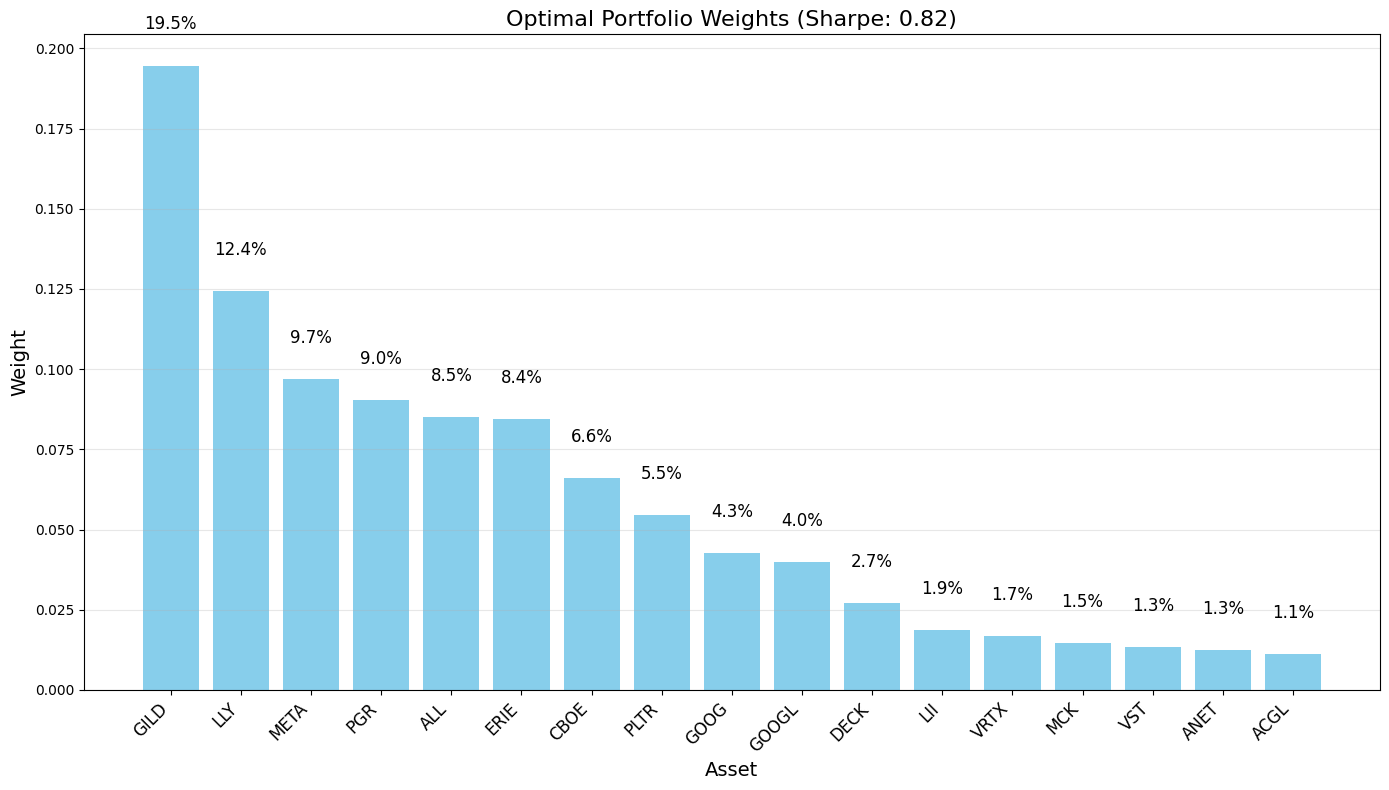

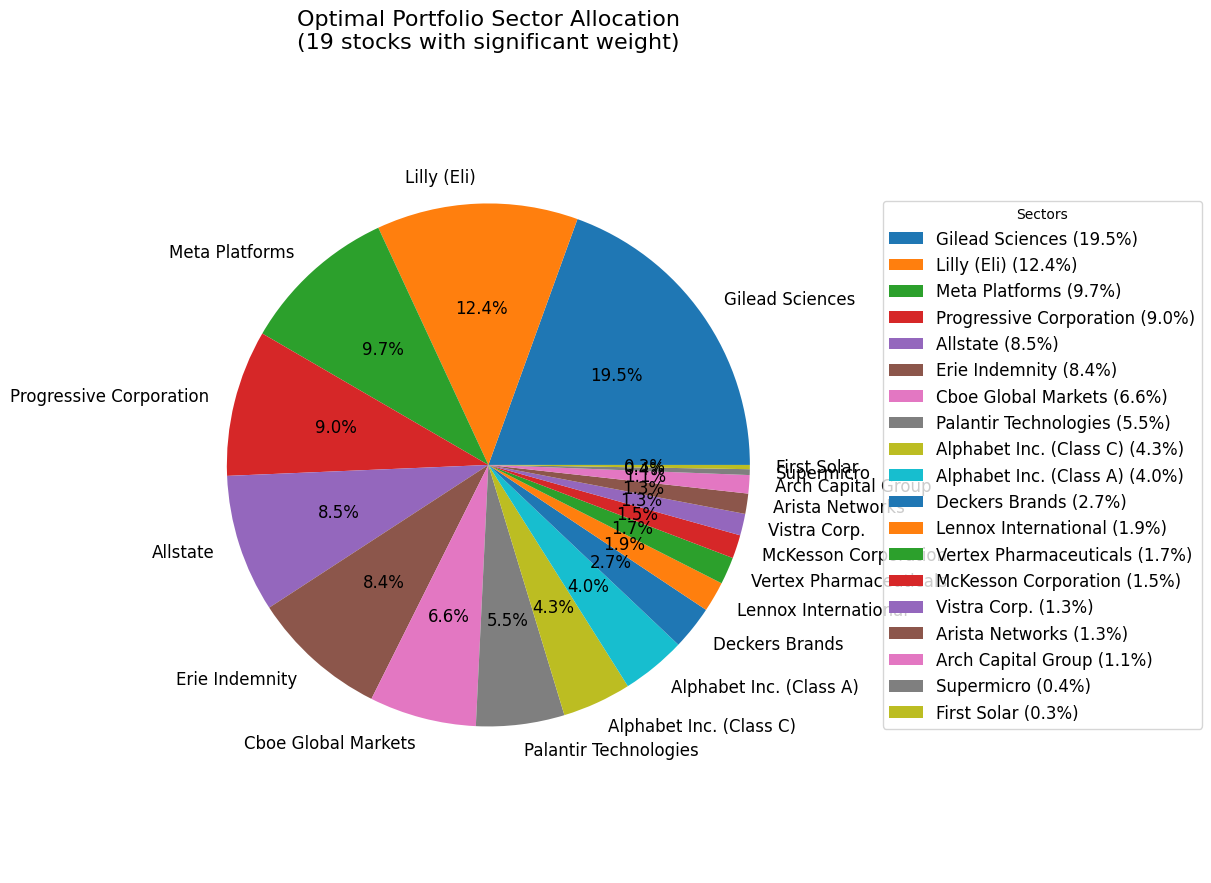

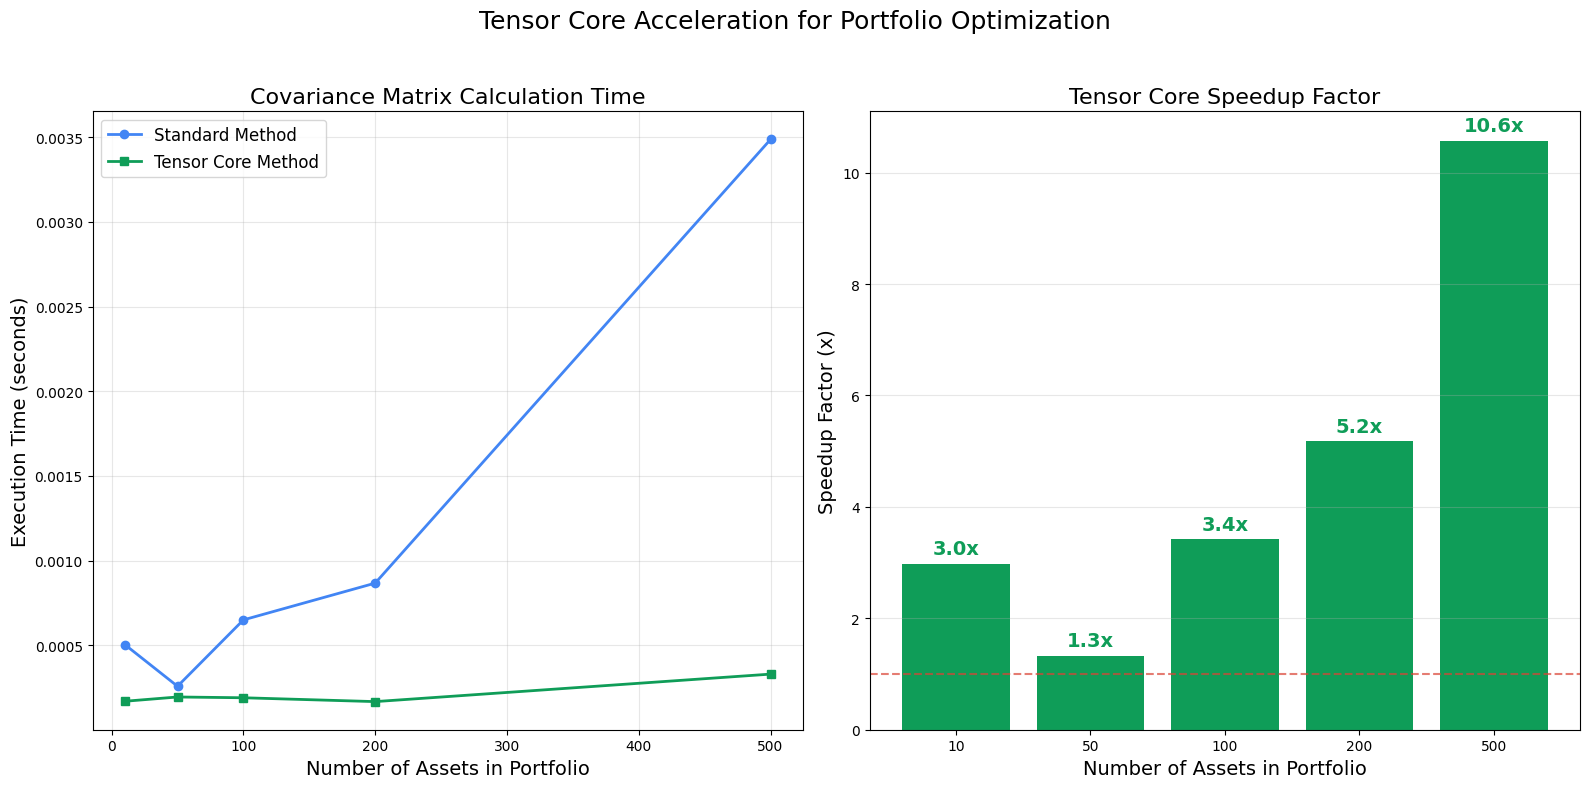

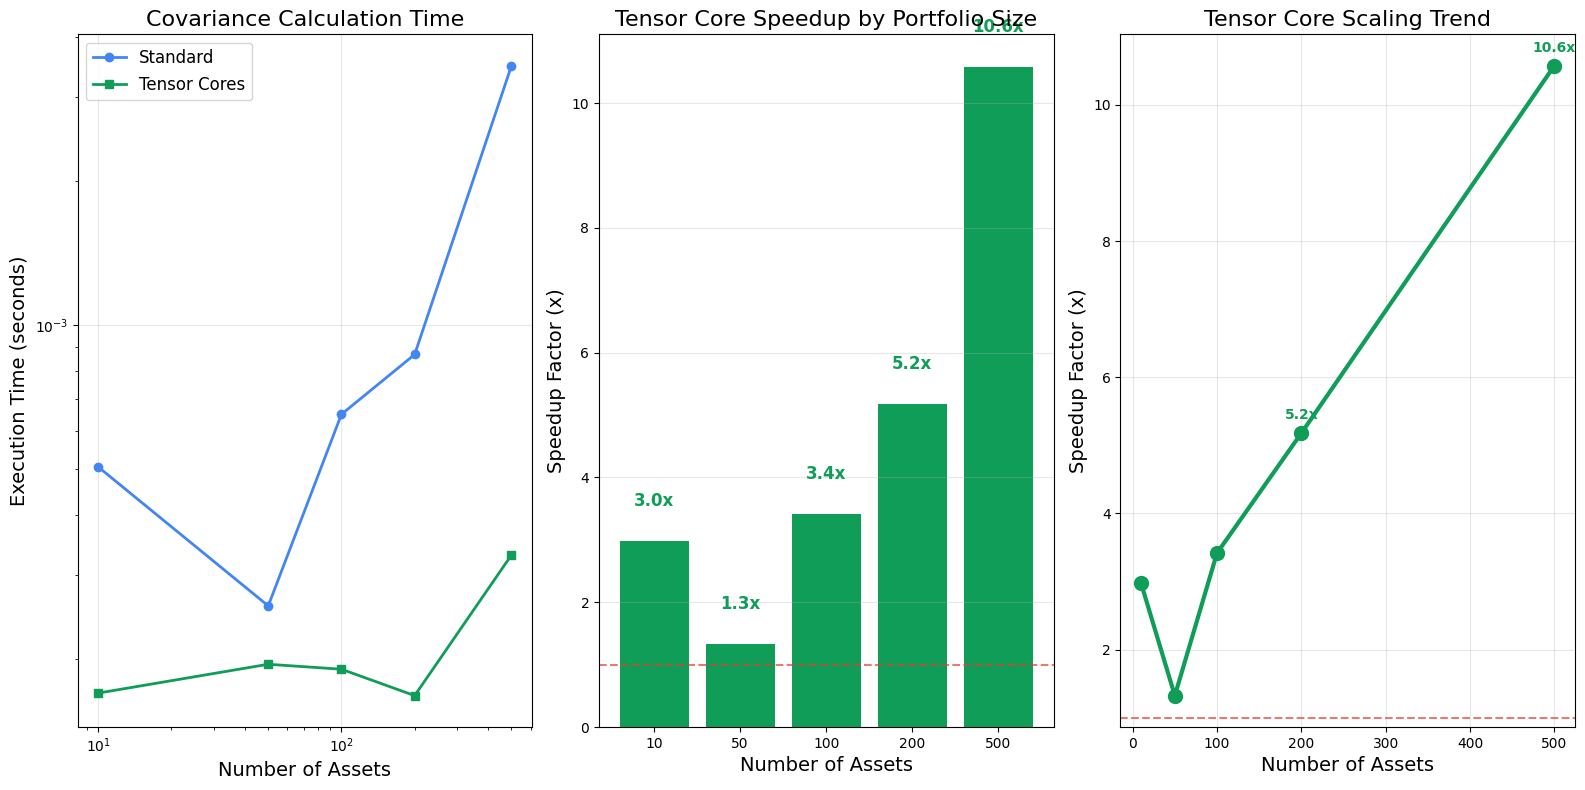

In [24]:
# For 500 stocks
plt.close('all')  # Close any existing figures
analyzer, results, optimal = run_sector_portfolio_demo()

# Then run the benchmark to see tensor core scaling
benchmark_results = run_covariance_benchmark()
# Generate the comprehensive benchmark visualization
comprehensive_plot = plot_comprehensive_benchmark(benchmark_results)